In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, precision_recall_curve, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

**TAKEAWAYS**

- Classification models are built on a dataset with product and user information, with the outcome as target
- The models return '1' if they predict a certain user will buy the selected product
- Dataset filtered to only show orders with more than 4 products
- The target class is very sparse (only 1.5% positives compared to negatives), which makes the classification harder
- Different algorithms are tried, displaying roc-auc curve and precision-recall curve as metrics
- Some hyperparameters are tweaked to compare the algorithms and select the best for the MVP
- Precision is prioritized when comparing the algorithms, as there is bigger downside for false positives

In [4]:
df = pd.read_csv('/home/alvaro/groceries/boxbuilder.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [5]:
df.created_at = pd.to_datetime(df.created_at)
df.order_date = pd.to_datetime(df.order_date,format='%Y-%m-%d %H:%M:%S')

In [4]:
df.order_id.nunique()

3446

In [6]:
# filter to only keep orders with more than 5 bought products
ids = df[df.outcome == 1].groupby('order_id').variant_id.count() > 4
ids[ids == True].index

Index([2807985930372, 2808027644036, 2808099078276, 2808393957508,
       2808434524292, 2808548917380, 2808549900420, 2808728715396,
       2808769085572, 2808786714756,
       ...
       3643189461124, 3643199160452, 3643226718340, 3643229274244,
       3643240185988, 3643241300100, 3643254800516, 3643274788996,
       3643283734660, 3643294515332],
      dtype='int64', name='order_id', length=2603)

2603 of the 3446 orders of the dataset have at least 5 bought products in them.

In [7]:
df2 = df[df.order_id.isin(ids[ids == True].index)]
df2.shape

(2163953, 27)

In [7]:
df2.outcome.value_counts()[1]/df2.outcome.value_counts()[0]*100

1.4690353292469747

Target is very unbalanced, with positive class rows being only 1.5% relative to the negative class. We will have to take this into account when training the model

In [8]:
cols_categoricas = df2[['variant_id','vendor','product_type']]
cols_categoricas.nunique()

variant_id      976
vendor          264
product_type     62
dtype: int64

In [ ]:
# Frequency encoding
for col in cols_categoricas.columns: 
    frequency_map = df2[col].value_counts(normalize=True).to_dict()
    df2.loc[:,f'{col}_freq_encoded'] = df2[col].map(frequency_map)
df3 = df2.drop(cols_categoricas.columns.to_list(), axis=1)

In [11]:
def test_model(model, X, y):
    '''Make predictions with the model and display the main score metrics'''
    
    y_pred = model.predict(X)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print('Confusion matrix:')
    print(conf_matrix)

    fpr, tpr, thresholds = roc_curve(y, y_pred)
    prec, rec, thresholds = precision_recall_curve(y, y_pred)

    fig, axs = plt.subplots(1,2, figsize=(8, 3))
    axs[0].plot(fpr, tpr)
    axs[1].plot(rec, prec)

    axs[0].set_xlabel('False positive rate')
    axs[0].set_ylabel('True positive rate')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    plt.show()
    plt.tight_layout()

In [12]:
drop = ["order_id",
    "user_id",
    "created_at",
    "order_date",
    'outcome']

X = df3.drop(drop, axis=1)  
y = df3.outcome
# train 0,6 and val+test 0,4
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=0)

# validation 0,2, test 0,2
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=0)

# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_val = scaler.transform(X_val) 
X_test = scaler.transform(X_test) 

The train, validation and test sets are assigned the arbitrary proportions of 0.6, 0.2 and 0.2 respectively. The data is also scaled as it works better for these models. As the target class is very unbalanced, class_weight='balanced' is utilized in the models.

Precision: 0.6025236593059937
Recall: 0.0625819134993447
Confusion matrix:
[[426435    252]
 [  5722    382]]


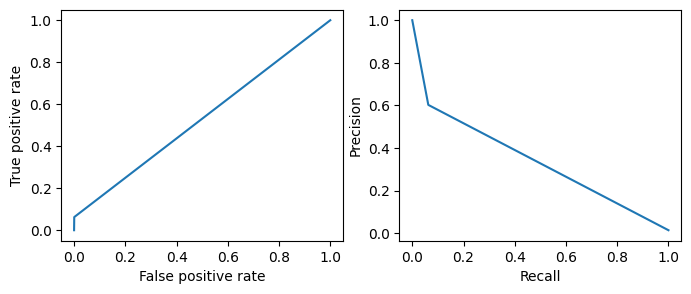

<Figure size 640x480 with 0 Axes>

In [13]:
# Create Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)
    
# validate    
test_model(model, X_val, y_val)

Precision is low but recall is very low. Class weights can be adjusted with the parameter class_weight='balanced' to do something about the low frequency of positive values for the outcome.

Precision: 0.055425088965407945
Recall: 0.6302424639580603
Confusion matrix:
[[361125  65562]
 [  2257   3847]]


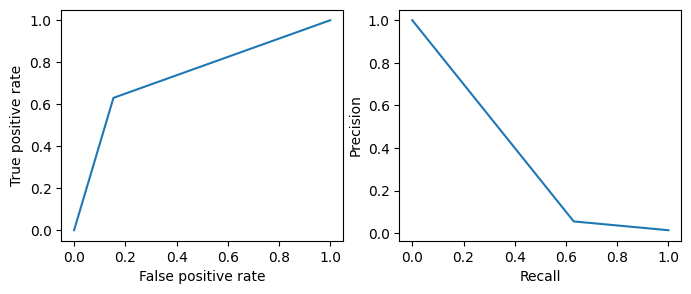

<Figure size 640x480 with 0 Axes>

In [14]:
# Create Logistic Regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
    
# validate    
test_model(model, X_val, y_val)

Recall gets better but the model becomes too loose so precision decreases. Other solvers can be tried to see if the scores improve. Also the regularization parameter can be increased to make the model more strict.

In [15]:
solvers = ['lbfgs','liblinear', 'newton-cholesky','saga']
results = {}

# Loop to try solvers
for solver in solvers:

    model = LogisticRegression(solver=solver)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    results[(solver)] = {'recall': recall, 'precision': precision}

# Display results
for solver, scores in results.items():
    recall = scores['recall']
    precision = scores['precision']
    print(f"solver: {solver} -> recall: {recall}, Precision: {precision:}")

solver: lbfgs -> recall: 0.0625819134993447, Precision: 0.6025236593059937
solver: liblinear -> recall: 0.0625819134993447, Precision: 0.6034755134281201
solver: newton-cholesky -> recall: 0.062418086500655307, Precision: 0.6018957345971564
solver: saga -> recall: 0.0625819134993447, Precision: 0.6034755134281201


In [16]:
# adjust regularization parameter C
Cs = [0.00001, 0.0001, 0.001,1]
results = {}

# Loop to try Cs
for C in Cs:

    model = LogisticRegression(solver='lbfgs',C=C)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    results[(C)] = {'recall': recall, 'precision': precision}

# Display results
for C, scores in results.items():
    recall = scores['recall']
    precision = scores['precision']
    print(f"C: {C} -> recall: {recall}, Precision: {precision:}")

C: 1e-05 -> recall: 0.01834862385321101, Precision: 0.6627218934911243
C: 0.0001 -> recall: 0.05799475753604194, Precision: 0.6424682395644283
C: 0.001 -> recall: 0.0625819134993447, Precision: 0.6092503987240829
C: 1 -> recall: 0.0625819134993447, Precision: 0.6025236593059937


Precision: 0.6424682395644283
Recall: 0.05799475753604194
Confusion matrix:
[[426490    197]
 [  5750    354]]


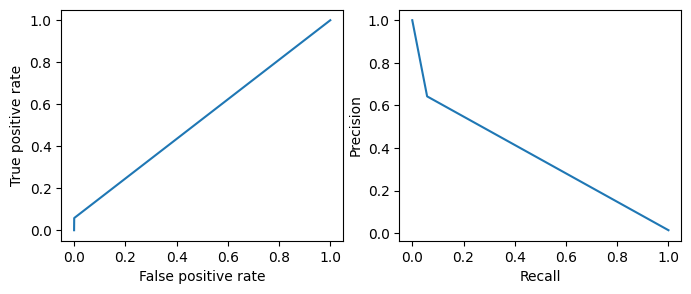

<Figure size 640x480 with 0 Axes>

In [17]:
# Create logistic regression model with stronger regularization
model = LogisticRegression(solver='lbfgs', C=0.0001)
model.fit(X_train, y_train)
    
# validate    
test_model(model, X_val, y_val)

Precision can be improved at cost of true positive detection by implementing a stronger regularization. Despite this, precision is still low so we must search for other alternatives.

Precision: 0.20464990537983238
Recall: 0.12401703800786369
Confusion matrix:
[[423745   2942]
 [  5347    757]]


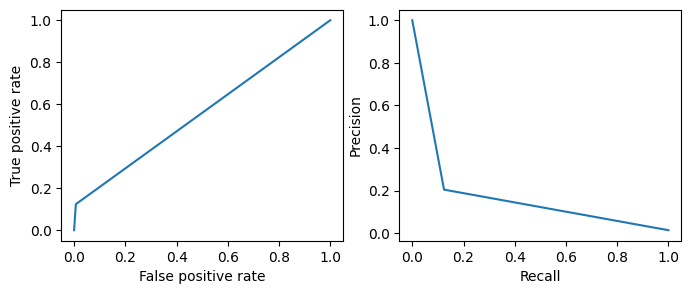

<Figure size 640x480 with 0 Axes>

In [18]:
# Create perceptron
model = Perceptron()
model.fit(X_train, y_train)

# validate    
test_model(model, X_val, y_val)

Perceptron performs bad if no penalty is implemented.

In [18]:
penalties = ['l2','l1','elasticnet']

# Initialize a dictionary to store results
results = {}

# Loop to try penalties and regularization parameters
for penalty in penalties:

    model = Perceptron(penalty=penalty)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Store the result
    results[(penalty)] = {'recall': recall, 'precision': precision}

# Display results
for penalty, scores in results.items():
    recall = scores['recall']
    precision = scores['precision']
    print(f"penalty: {penalty} -> recall: {recall}, Precision: {precision:}")

penalty: l2 -> recall: 0.07547169811320754, Precision: 0.06968641114982578
penalty: l1 -> recall: 0.04298605414273995, Precision: 0.7507163323782235
penalty: elasticnet -> recall: 0.04298605414273995, Precision: 0.7507163323782235


In [22]:
alphas = [0.00001, 0.0001, 0.001]

# Initialize a dictionary to store results
results = {}

# Loop to try alphas and regularization parameters
for alpha in alphas:

    model = Perceptron(penalty='elasticnet',alpha=alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Store the result
    results[(alpha)] = {'recall': recall, 'precision': precision}

# Display results
for alpha, scores in results.items():
    recall = scores['recall']
    precision = scores['precision']
    print(f"alpha: {alpha} -> recall: {recall}, Precision: {precision:}")

alpha: 1e-05 -> recall: 0.03199343724364233, Precision: 0.07517347725520432
alpha: 0.0001 -> recall: 0.04298605414273995, Precision: 0.7507163323782235
alpha: 0.001 -> recall: 0.07169811320754717, Precision: 0.24143646408839778


Precision is much better with this model. In our case, precision may be prioritized over recall since the downside of getting too much false positives is big, resulting in the users receiving many push notifications of products they are not interested in, thus making them uninstall the app. Therefore, perhaps the best option is to select perceptron model over logistic regression.

In [19]:
alphas = [0.001, 1, 100]

# Initialize a dictionary to store results
results = {}

# Loop to try alphas and regularization parameters
for alpha in alphas:

    model = RidgeClassifier(alpha=alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Store the result
    results[(alpha)] = {'recall': recall, 'precision': precision}

# Display results
for alpha, scores in results.items():
    recall = scores['recall']
    precision = scores['precision']
    print(f"alpha: {alpha} -> recall: {recall}, Precision: {precision:}")

alpha: 0.001 -> recall: 0.04750982961992136, Precision: 0.7859078590785907
alpha: 1 -> recall: 0.04750982961992136, Precision: 0.7859078590785907
alpha: 100 -> recall: 0.04750982961992136, Precision: 0.7859078590785907


Precision: 0.7859078590785907
Recall: 0.04750982961992136
Confusion matrix:
[[426608     79]
 [  5814    290]]


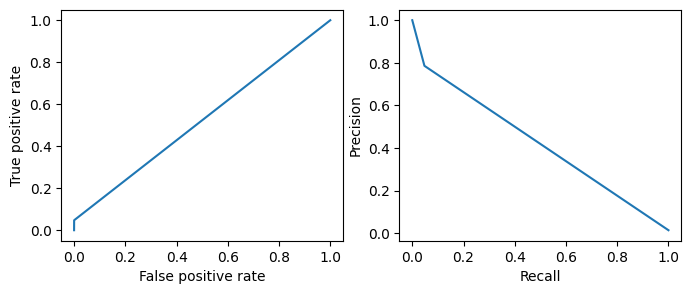

<Figure size 640x480 with 0 Axes>

In [20]:
# Create ridge classifier
model = RidgeClassifier()
model.fit(X_train, y_train)
    
# validate    
test_model(model, X_val, y_val)

In [21]:
Cs = [0.0000001, 0.0001, 1, 100]
results = {}

# Loop to try Cs
for C in Cs:
    model = LinearSVC(C=C)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Store the result
    results[(C)] = {'recall': recall, 'precision': precision}

# Display results
for C, scores in results.items():
    recall = scores['recall']
    precision = scores['precision']
    print(f"C: {C} -> recall: {recall}, Precision: {precision:}")

C: 1e-07 -> recall: 0.05144167758846658, Precision: 0.7696078431372549
C: 0.0001 -> recall: 0.04750982961992136, Precision: 0.7859078590785907
C: 1 -> recall: 0.04750982961992136, Precision: 0.7859078590785907
C: 100 -> recall: 0.04750982961992136, Precision: 0.7859078590785907


Precision: 0.7834224598930482
Recall: 0.048001310615989515
Confusion matrix:
[[426606     81]
 [  5811    293]]


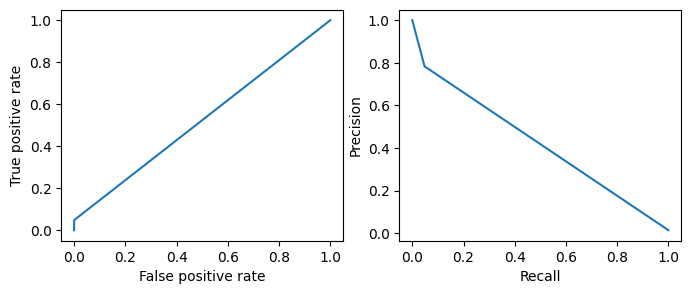

<Figure size 640x480 with 0 Axes>

In [22]:
# Create svm
model = LinearSVC(C=0.000001)
model.fit(X_train, y_train)

# validate    
test_model(model, X_val, y_val)

Precision: 0.7717391304347826
Recall: 0.044972288202692
Confusion matrix:
[[426392     84]
 [  6031    284]]


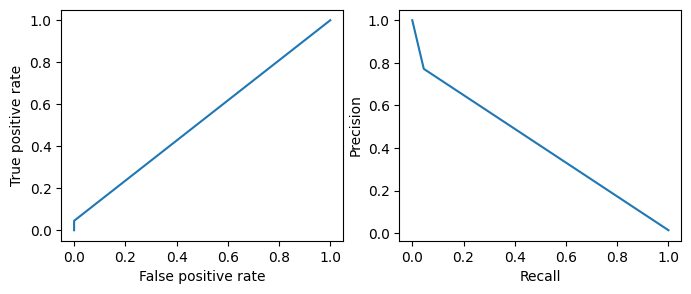

<Figure size 640x480 with 0 Axes>

In [23]:
test_model(model, X_test, y_test)